In [2]:
from import_all import *

In [3]:
file_path1 = '../emg+dataset+in+lower+limb/SEMG_DB1/N_TXT/8Nmar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX'])
    data.dropna(inplace=True)
    data['Time'] = data.index/1000
    return data

#Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

#Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)


data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])

data["FX"]=abs(data["FX"])

print(data.head())

         RF        BF        VM        ST   FX   Time
0 -0.000240  0.000637  0.000141  0.000464  4.2  0.000
1 -0.001143  0.002757 -0.001902  0.014242  4.2  0.001
2 -0.000609  0.011578 -0.002467  0.033072  4.2  0.002
3  0.000711  0.020553 -0.002365  0.051522  4.2  0.003
4  0.000579  0.011352 -0.002078  0.050225  4.2  0.004


In [4]:
# Détection améliorée des cycles de marche
signal = data['FX']
threshold = 0.5 * np.max(signal)  # Seuil ajusté dynamiquement

cycle_diffs = np.diff(np.where(signal > threshold)[0])
distance = int(np.mean(cycle_diffs)) if len(cycle_diffs) > 0 else 200  # Valeur par défaut

peaks, _ = find_peaks(signal, height=threshold, prominence=5, distance=distance)

# Vérification de la cohérence des cycles
if len(peaks) > 1:
    cycle_lengths = np.diff(peaks)
    mean_cycle_length = np.mean(cycle_lengths)
else:
    mean_cycle_length = 1000  # Valeur par défaut si un seul pic est trouvé

# Détection des débuts de cycles ajustés
shift_ratio = 0.7
adjusted_peaks = []
for i in range(len(peaks)):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = peaks[i] - shift_amount
    adjusted_peaks.append(adjusted_start)

print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(f'Débuts de cycles ajustés : {adjusted_peaks}')

# Verification du premier cycle
print(len(adjusted_peaks))
for i in range(len(adjusted_peaks)):
    if adjusted_peaks[0] < 0 :
        adjusted_peaks.pop(0)
        print(f'Premier cycle supprimé : {adjusted_peaks}')
    else:
        print(f'Premier cycle valide : {adjusted_peaks}')
        break

cycle_lengths = np.diff(adjusted_peaks)
mean_cycle_length = np.mean(cycle_lengths)

# Calcul du temps moyen des cycles **normaux** (excluant les cycles corrompus)
normal_cycle_times = [t for t in cycle_lengths if t > 1000]
mean_normal_cycle_time = np.mean(normal_cycle_times)



print(f'Temps pour chaque cycle : {cycle_lengths}')
print(f'Temps moyen des cycles normaux : {mean_normal_cycle_time:.2f}')

#Détection et correction des cycles anormaux
new_adjusted_peaks = []
for i in range(len(adjusted_peaks) - 1):
    start_time = data['Time'][adjusted_peaks[i]]
    end_time = data['Time'][adjusted_peaks[i + 1]]
    cycle_time = (end_time - start_time)*1000


    if cycle_time >= 1.50 * mean_normal_cycle_time:
        num_splits = round(cycle_time / mean_normal_cycle_time)  # Nombre de nouveaux cycles
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, divisé en {num_splits} cycles.')

        # Ajout des nouveaux débuts de cycle répartis uniformément
        for j in range(num_splits):
            new_peak = adjusted_peaks[i] + int(j * mean_normal_cycle_time / (data['Time'][1]*1000 - data['Time'][0]*1000))
            new_adjusted_peaks.append(new_peak)
    elif cycle_time <= 0.50 * mean_normal_cycle_time:
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, supprimé.')
    else:
        new_adjusted_peaks.append(adjusted_peaks[i])

# Ajout du dernier pic s'il n'a pas été traité
if adjusted_peaks:
    new_adjusted_peaks.append(adjusted_peaks[-1])

adjusted_peaks = new_adjusted_peaks

# Affichage des nouveaux débuts de cycles
print(f'Nouveaux débuts de cycles ajustés : {adjusted_peaks}')

# Début d'un nouveau cycle même si il n'y a pas de peak
if adjusted_peaks[-1]+int(np.mean(np.diff(adjusted_peaks))) < len(data):
    adjusted_peaks.append(adjusted_peaks[-1] + int(np.mean(np.diff(adjusted_peaks))))
    print(f'Ajout d\'un début de nouveau cycle : {adjusted_peaks}')
else:
    print(f'Aucun nouveau cycle ajouté : {adjusted_peaks}')

# Suppression des 3 premiers et 3 derniers cycles si le nombre total de cycles est supérieur à 20
if len(adjusted_peaks) > 20:
    adjusted_peaks = adjusted_peaks[3:-3]
    print(f'Suppression des 3 premiers et 3 derniers cycles : {adjusted_peaks}')

Nombre de débuts de cycles ajustés : 6
Débuts de cycles ajustés : [-286, 1255, 2714, 4198, 5780, 7322]
6
Premier cycle supprimé : [1255, 2714, 4198, 5780, 7322]
Premier cycle valide : [1255, 2714, 4198, 5780, 7322]
Temps pour chaque cycle : [1459 1484 1582 1542]
Temps moyen des cycles normaux : 1516.75
Nouveaux débuts de cycles ajustés : [1255, 2714, 4198, 5780, 7322]
Ajout d'un début de nouveau cycle : [1255, 2714, 4198, 5780, 7322, 8838]


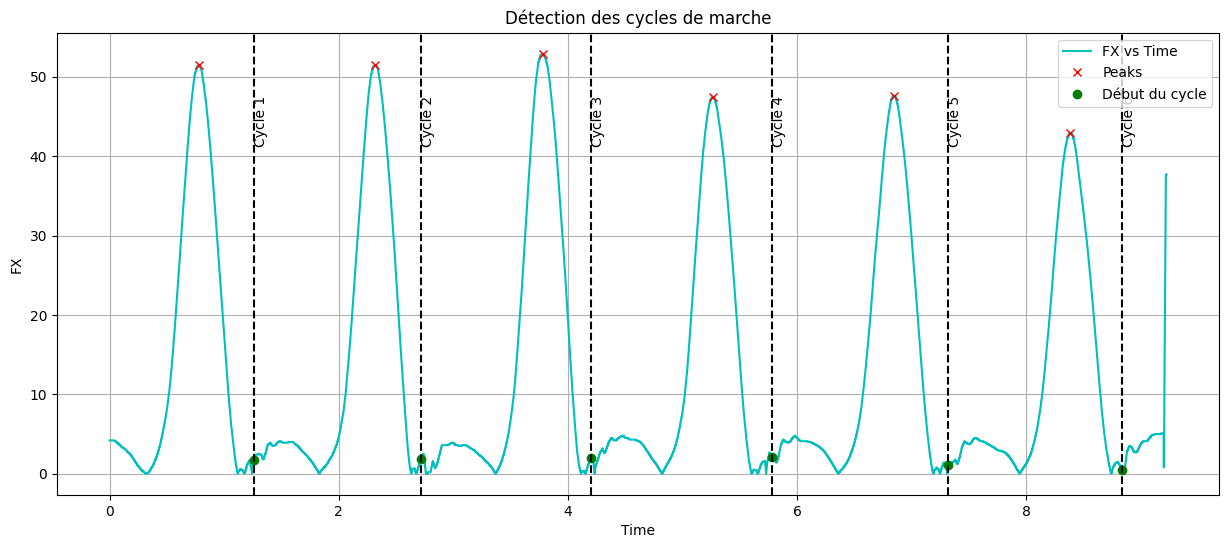

In [5]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# On calcul le temps de chaque cycle et on divise par la fréquence d'échantillonnage pour obtenir le temps en secondes
cycle_durations = np.diff(adjusted_peaks) / 1000 

# Calcul du temps de cycle moyen
average_cycle_time = np.mean(cycle_durations)

print(f"Durée de chaque cycles (en secondes): {cycle_durations}")
print(f"Temps moyen de cycle (en secondes): {average_cycle_time}")

Durée de chaque cycles (en secondes): [1.459 1.484 1.582 1.542 1.516]
Temps moyen de cycle (en secondes): 1.5166


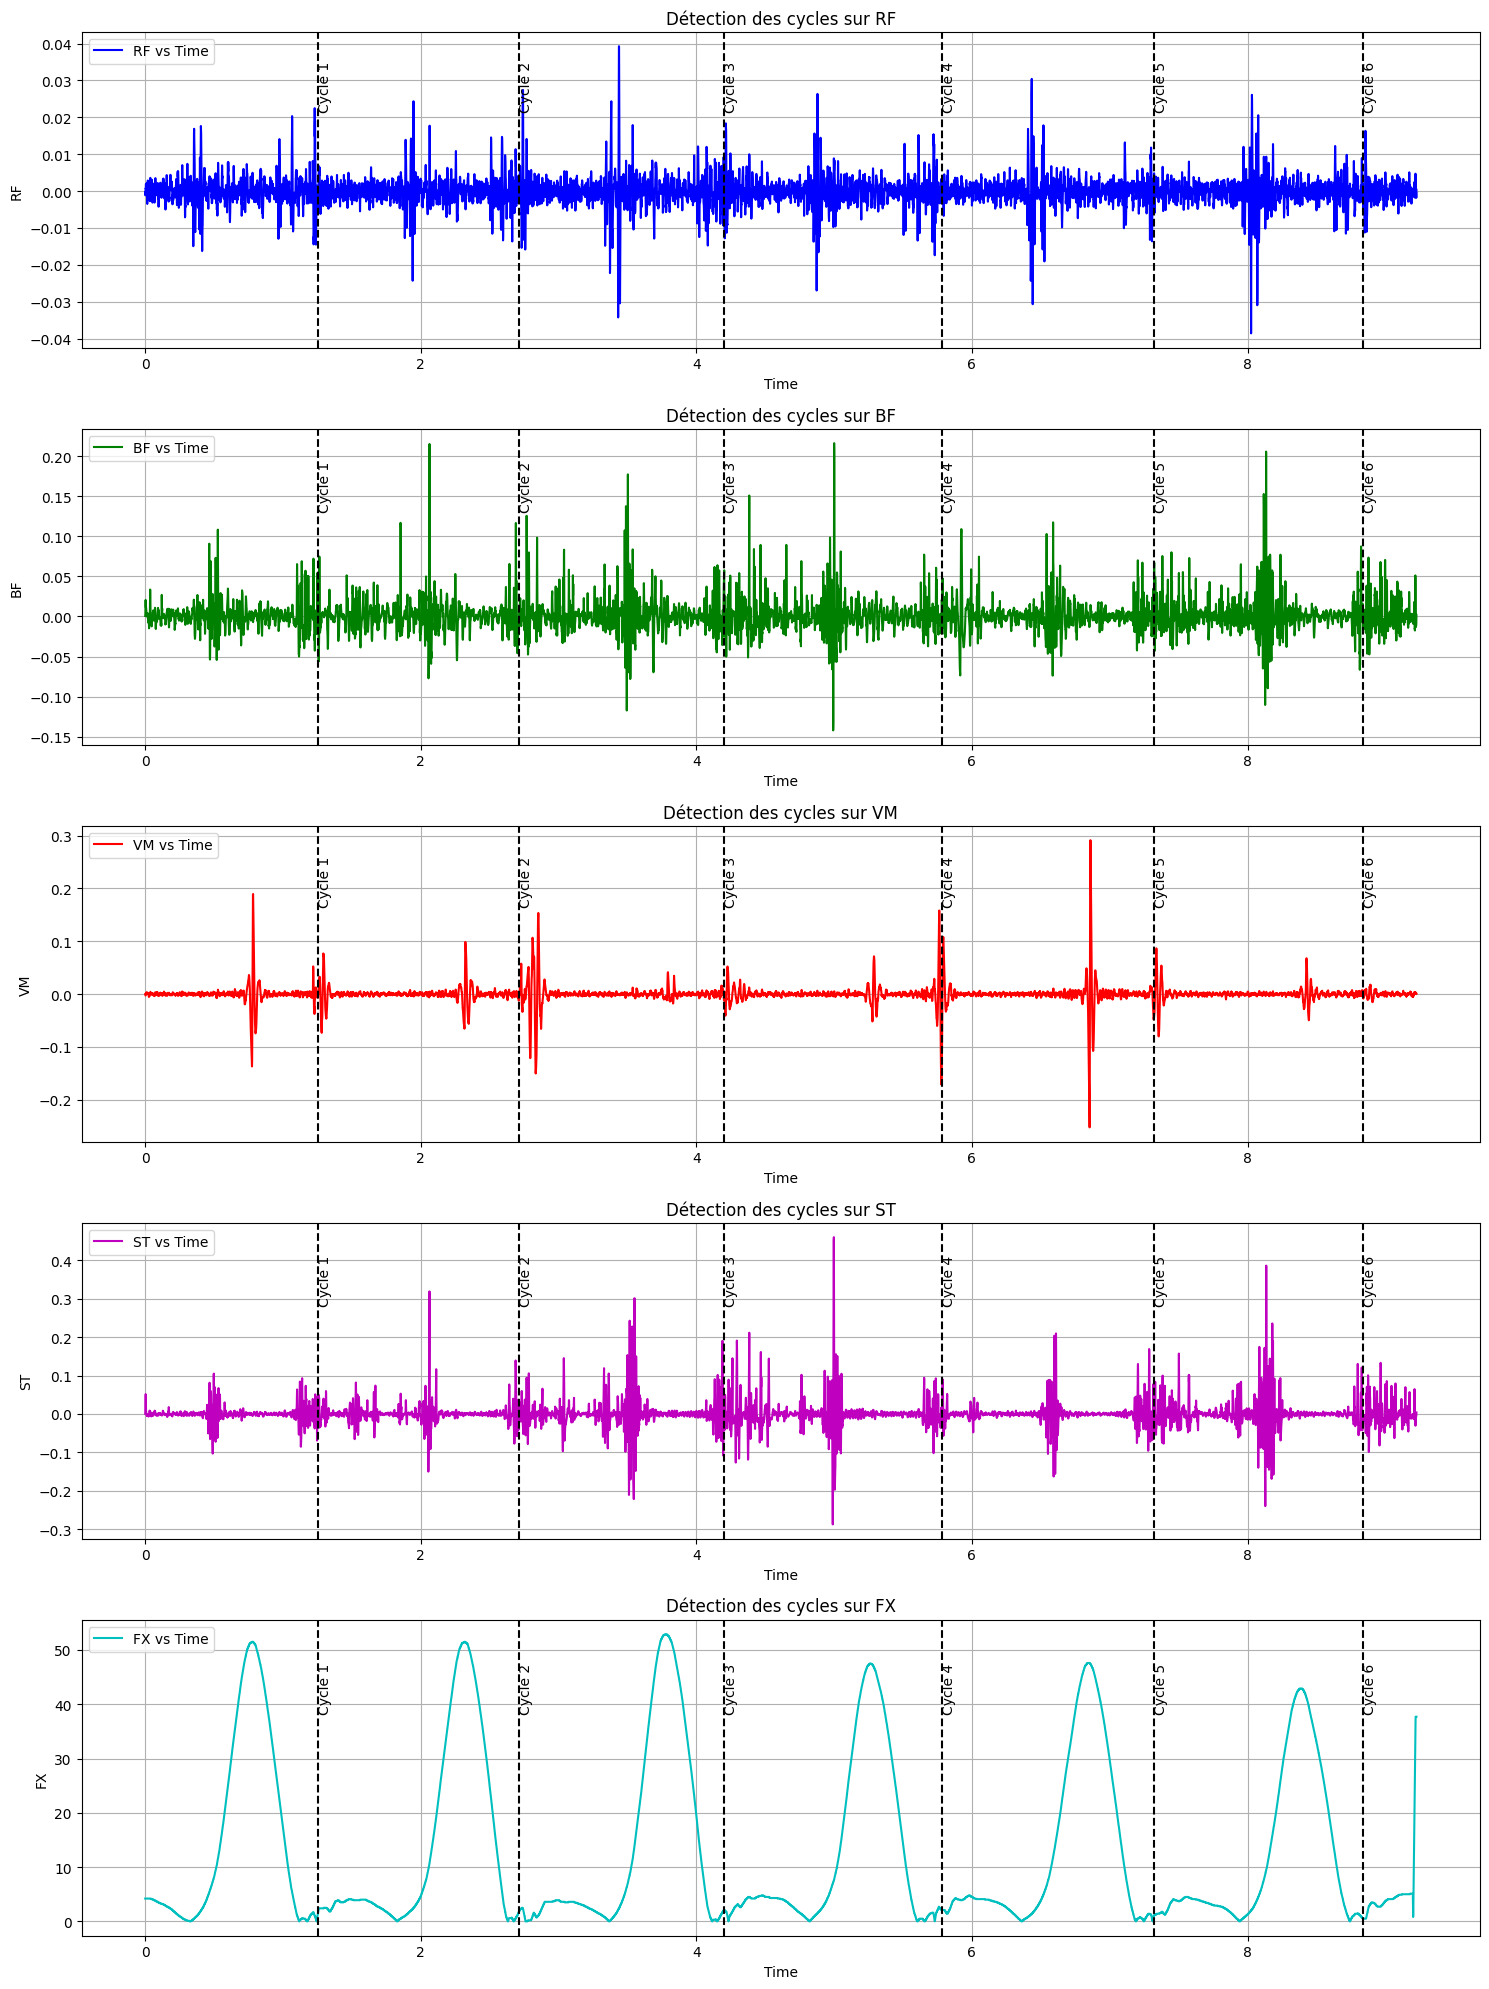

In [7]:
# Liste des colonnes à afficher
columns = ['RF', 'BF', 'VM', 'ST', 'FX']
colors = ['b', 'g', 'r', 'm', 'c']

# Création des graphiques pour chaque signal avec les cycles marqués
fig, axs = plt.subplots(len(columns), figsize=(15, 20))
for i, col in enumerate(columns):
    axs[i].plot(data['Time'], data[col], label=f'{col} vs Time', color=colors[i])
    for j, start in enumerate(adjusted_peaks):
        axs[i].axvline(x=data['Time'][start], color='k', linestyle='--')
        axs[i].text(data['Time'][start], max(data[col]) * 0.9, f'Cycle {j+1}', rotation=90, verticalalignment='top')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(col)
    axs[i].set_title(f'Détection des cycles sur {col}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Convert float values in adjusted_peaks to integers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# RMS (Root Mean Square) pour chaque cycle
rms_values_RF = []
rms_values_BF = []
rms_values_VM = []
rms_values_ST = []
for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    rms_RF = np.sqrt(np.mean(data['RF'][start:end] ** 2))
    rms_values_RF.append(rms_RF)
    rms_BF = np.sqrt(np.mean(data['BF'][start:end] ** 2))
    rms_values_BF.append(rms_BF)
    rms_VM = np.sqrt(np.mean(data['VM'][start:end] ** 2))
    rms_values_VM.append(rms_VM)
    rms_ST = np.sqrt(np.mean(data['ST'][start:end] ** 2))
    rms_values_ST.append(rms_ST)


print(rms_values_RF)
print(rms_values_BF)
print(rms_values_VM)
print(rms_values_ST)

mean_rms_RF = np.mean(rms_values_RF)
mean_rms_BF = np.mean(rms_values_BF)
mean_rms_VM = np.mean(rms_values_VM)
mean_rms_ST = np.mean(rms_values_ST)

print(f'Mean RMS RF: {mean_rms_RF:.4f}')
print(f'Mean RMS BF: {mean_rms_BF:.4f}')
print(f'Mean RMS VM: {mean_rms_VM:.4f}')
print(f'Mean RMS ST: {mean_rms_ST:.4f}')

[0.0035983996242740113, 0.005121752236471088, 0.004054520679631757, 0.0038786058123217873, 0.003968804619147827]
[0.018836505634644063, 0.02116311128388632, 0.02132830413688112, 0.017628716667770123, 0.020086765016921988]
[0.014328550126721665, 0.02190064325692154, 0.017768546521998052, 0.02844125010742745, 0.012104772894820417]
[0.023360597135070046, 0.037348331018397456, 0.04123446356415774, 0.025443097943008315, 0.03755266529671262]
Mean RMS RF: 0.0041
Mean RMS BF: 0.0198
Mean RMS VM: 0.0189
Mean RMS ST: 0.0330


In [9]:
#Energie pour chaque cycle

energie_values_RF = []
energie_values_BF = []
energie_values_VM = []
energie_values_ST = []

for i in range(len(adjusted_peaks) - 1):
    start = adjusted_peaks[i]
    end = adjusted_peaks[i + 1]
    energie_RF = np.sum(np.square(data['RF'][start:end]))
    energie_values_RF.append(energie_RF)
    energie_BF = np.sum(np.square(data['BF'][start:end]))
    energie_values_BF.append(energie_BF)
    energie_VM = np.sum(np.square(data['VM'][start:end]))
    energie_values_VM.append(energie_VM)
    energie_ST = np.sum(np.square(data['ST'][start:end]))
    energie_values_ST.append(energie_ST)

print(energie_values_RF)
print(energie_values_BF)
print(energie_values_VM)
print(energie_values_ST)

mean_energie_RF = np.mean(energie_values_RF)
mean_energie_BF = np.mean(energie_values_BF)
mean_energie_VM = np.mean(energie_values_VM)
mean_energie_ST = np.mean(energie_values_ST)

print(f'Mean Energie RF: {mean_energie_RF:.4f}')
print(f'Mean Energie BF: {mean_energie_BF:.4f}')
print(f'Mean Energie VM: {mean_energie_VM:.4f}')
print(f'Mean Energie ST: {mean_energie_ST:.4f}')


[0.01889183210986803, 0.038928801422146136, 0.026006716223550393, 0.023197205059054336, 0.023879137719133196]
[0.5176735450604832, 0.6646498823538082, 0.7196463537360851, 0.47920988638557993, 0.6116728433290821]
[0.29954342180287014, 0.7117830517993433, 0.49947101038797515, 1.247331059232139, 0.22213269868213142]
[0.7962018303217754, 2.0700283795119274, 2.689844518940534, 0.9982156011896464, 2.1378672490645774]
Mean Energie RF: 0.0262
Mean Energie BF: 0.5986
Mean Energie VM: 0.5961
Mean Energie ST: 1.7384


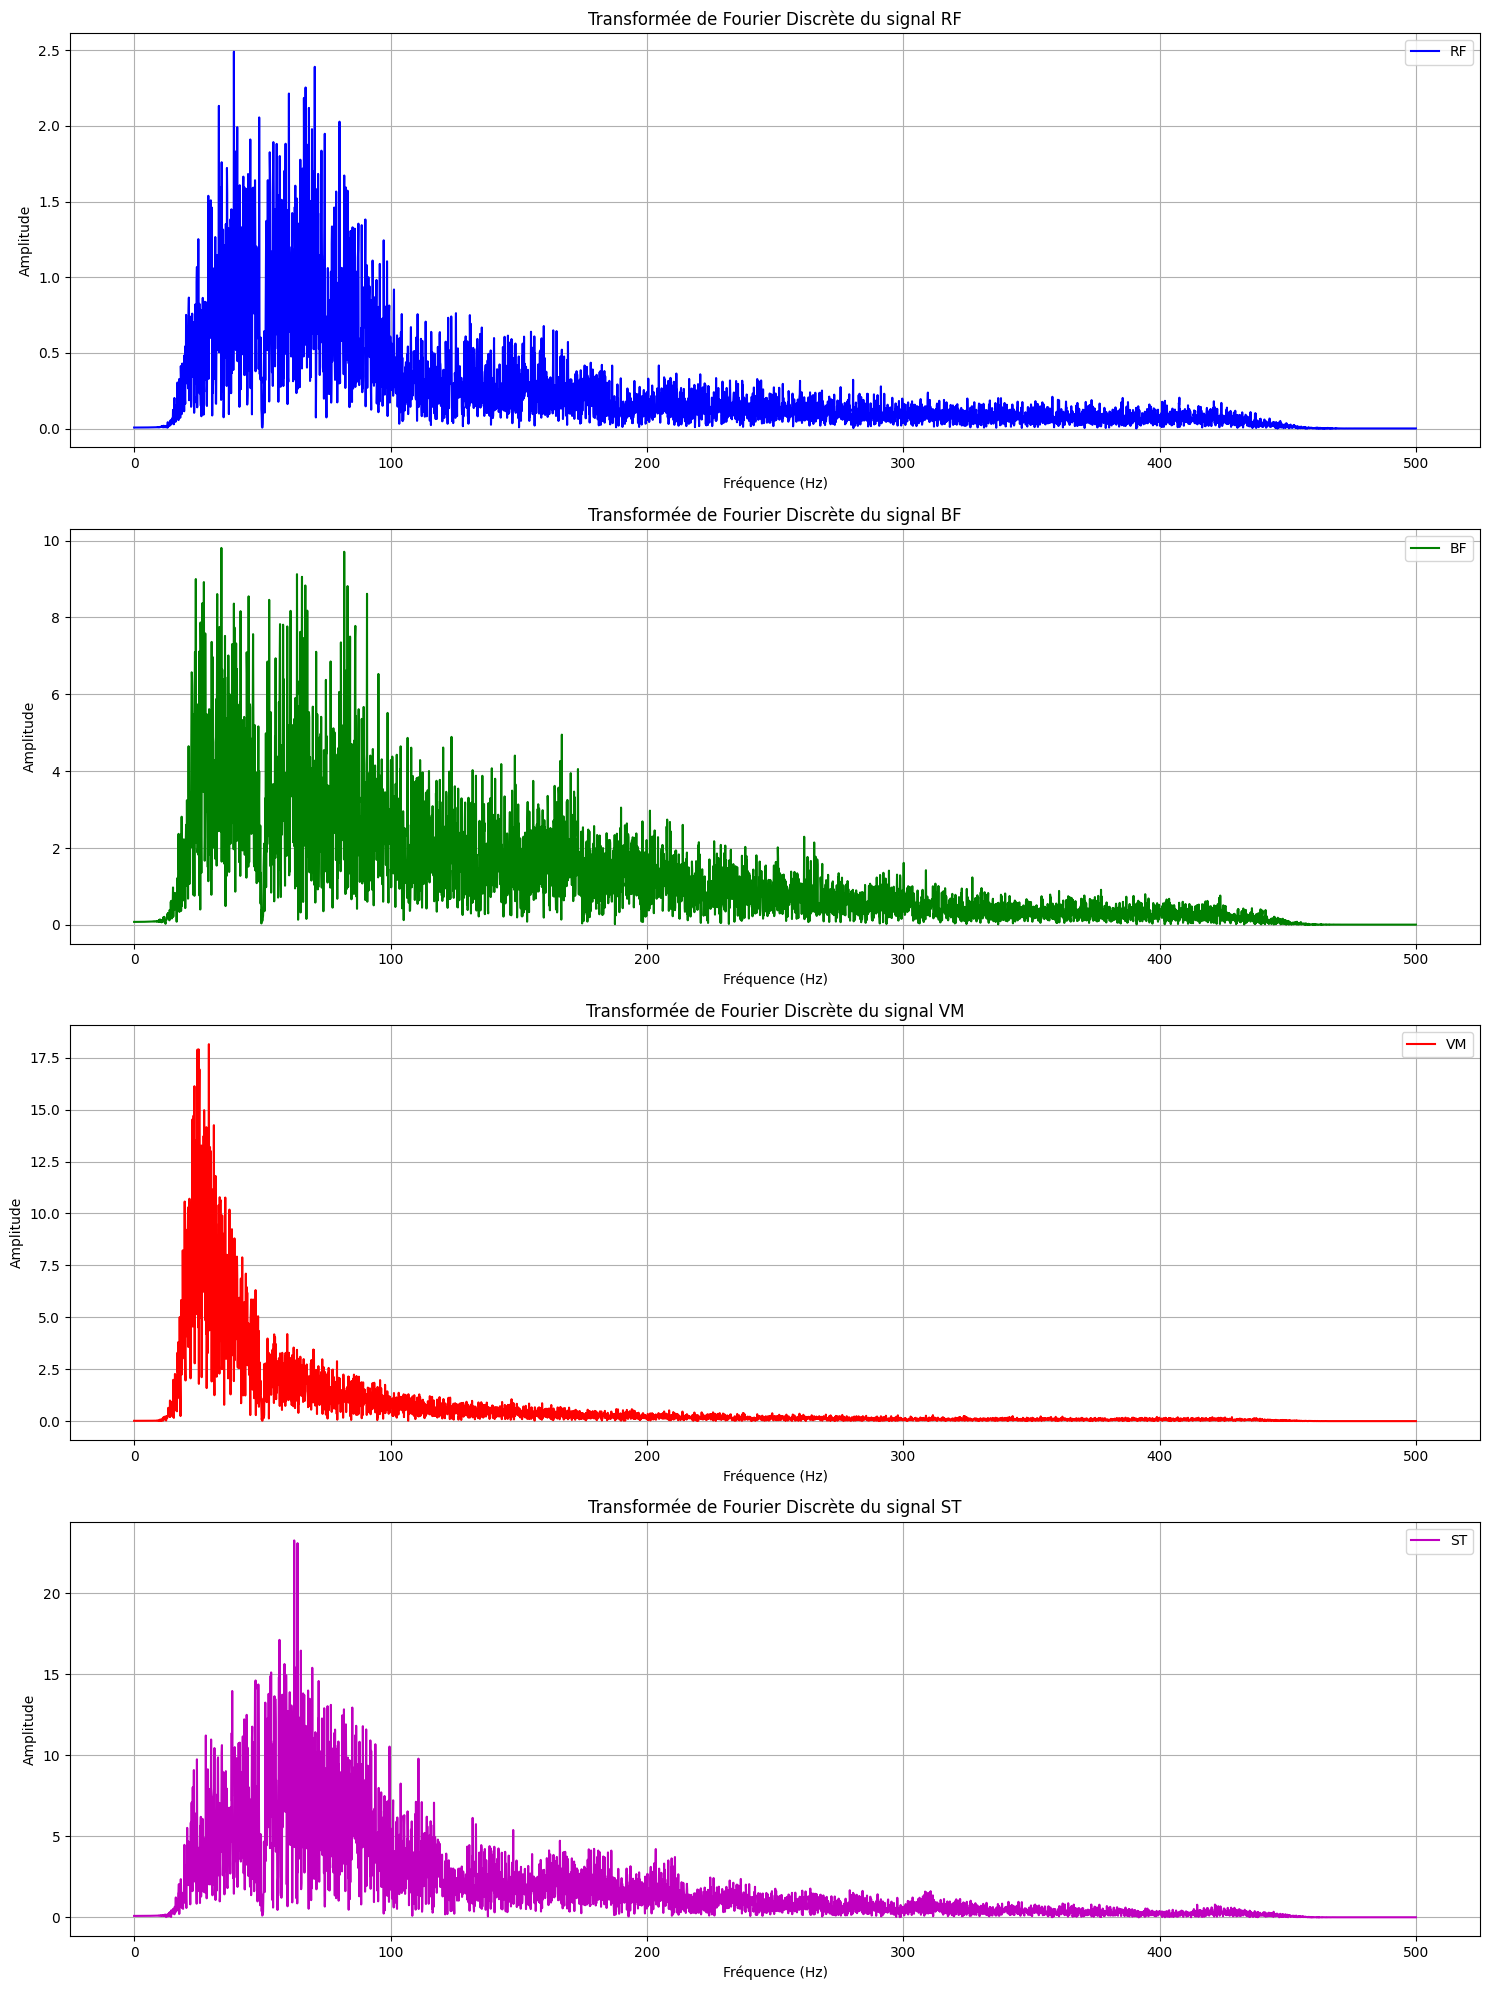

In [10]:
def transform_signal_to_frequency_domain(data, fs=1000):
    T = 1 / fs  # Période d'échantillonnage

    # Calcul de la Transformée de Fourier Discrète
    X = np.fft.fft(data)

    # Calcul des fréquences associées
    n = len(data)  # Nombre d'échantillons
    frequencies = np.fft.fftfreq(n, T)

    # Sélection des fréquences positives pour une meilleure visualisation
    positive_frequencies = frequencies[:n // 2]
    positive_X = X[:n // 2]

    # Calcul de l'amplitude du signal fréquentiel
    amplitude = np.abs(positive_X)

    return positive_frequencies, amplitude

# Transformation des signaux en domaine fréquentiel
frequencies, amplitude_RF = transform_signal_to_frequency_domain(data['RF'])
_, amplitude_BF = transform_signal_to_frequency_domain(data['BF'])
_, amplitude_VM = transform_signal_to_frequency_domain(data['VM'])
_, amplitude_ST = transform_signal_to_frequency_domain(data['ST'])

# Affichage des signaux en domaine fréquentiel sur des graphiques séparés
fig, axs = plt.subplots(4, 1, figsize=(15, 20))

axs[0].plot(frequencies, amplitude_RF, label='RF', color='b')
axs[0].set_xlabel('Fréquence (Hz)')
axs[0].set_ylabel('Amplitude')
axs[0].set_title('Transformée de Fourier Discrète du signal RF')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(frequencies, amplitude_BF, label='BF', color='g')
axs[1].set_xlabel('Fréquence (Hz)')
axs[1].set_ylabel('Amplitude')
axs[1].set_title('Transformée de Fourier Discrète du signal BF')
axs[1].legend()
axs[1].grid(True)

axs[2].plot(frequencies, amplitude_VM, label='VM', color='r')
axs[2].set_xlabel('Fréquence (Hz)')
axs[2].set_ylabel('Amplitude')
axs[2].set_title('Transformée de Fourier Discrète du signal VM')
axs[2].legend()
axs[2].grid(True)

axs[3].plot(frequencies, amplitude_ST, label='ST', color='m')
axs[3].set_xlabel('Fréquence (Hz)')
axs[3].set_ylabel('Amplitude')
axs[3].set_title('Transformée de Fourier Discrète du signal ST')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout()
plt.show()


In [11]:
# Convertir les valeurs des pics en entiers
adjusted_peaks = [int(peak) for peak in adjusted_peaks]

# Initialisation des listes pour stocker les Mean Frequency (MF) par cycle
mf_values_RF = []
mf_values_BF = []
mf_values_VM = []
mf_values_ST = []

# Calcul de la puissance du signal fréquentiel
power_RF = amplitude_RF ** 2
power_BF = amplitude_BF ** 2
power_VM = amplitude_VM ** 2
power_ST = amplitude_ST ** 2

# Calcul de la Mean Frequency (MF) pour chaque muscle
mf_RF = np.sum(frequencies * power_RF) / np.sum(power_RF)
mf_BF = np.sum(frequencies * power_BF) / np.sum(power_BF)
mf_VM = np.sum(frequencies * power_VM) / np.sum(power_VM)
mf_ST = np.sum(frequencies * power_ST) / np.sum(power_ST)

# Affichage des résultats
print("MF pour RF :", mf_RF)
print("MF pour BF :", mf_BF)
print("MF pour VM :", mf_VM)
print("MF pour ST :", mf_ST)


MF pour RF : 77.05081019329224
MF pour BF : 87.32085413108122
MF pour VM : 34.91647373463856
MF pour ST : 77.93836249202414
